In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.0 MB/s eta 0:00:00


Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7
Has isolated nodes: False
GAT(
  (gat1): GATv2Conv(1433, 8, heads=8)
  (gat2): GATv2Conv(64, 7, heads=1)
)
Epoch   0 | Train Loss: 1.967 | Train Acc:  11.43% | Val Loss: 1.95 | Val Acc: 14.60%
Epoch  10 | Train Loss: 0.084 | Train Acc:  99.29% | Val Loss: 0.75 | Val Acc: 77.40%
Epoch  20 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 0.87 | Val Acc: 77.00%
Epoch  30 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.02 | Val Acc: 74.80%
Epoch  40 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.03 | Val Acc: 73.60%
Epoch  50 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.88 | Val Acc: 74.40%
Epoch  60 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 0.84 | Val Acc: 75.80%
Epoch  70 | Train Loss: 0.010 | Train Acc: 100.00% | Val Loss: 0.85 | Val Acc: 76.00%
Epoch  80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 0.87 | Val Acc: 75.60%
Epoch  90 | Train Loss: 0.009 |

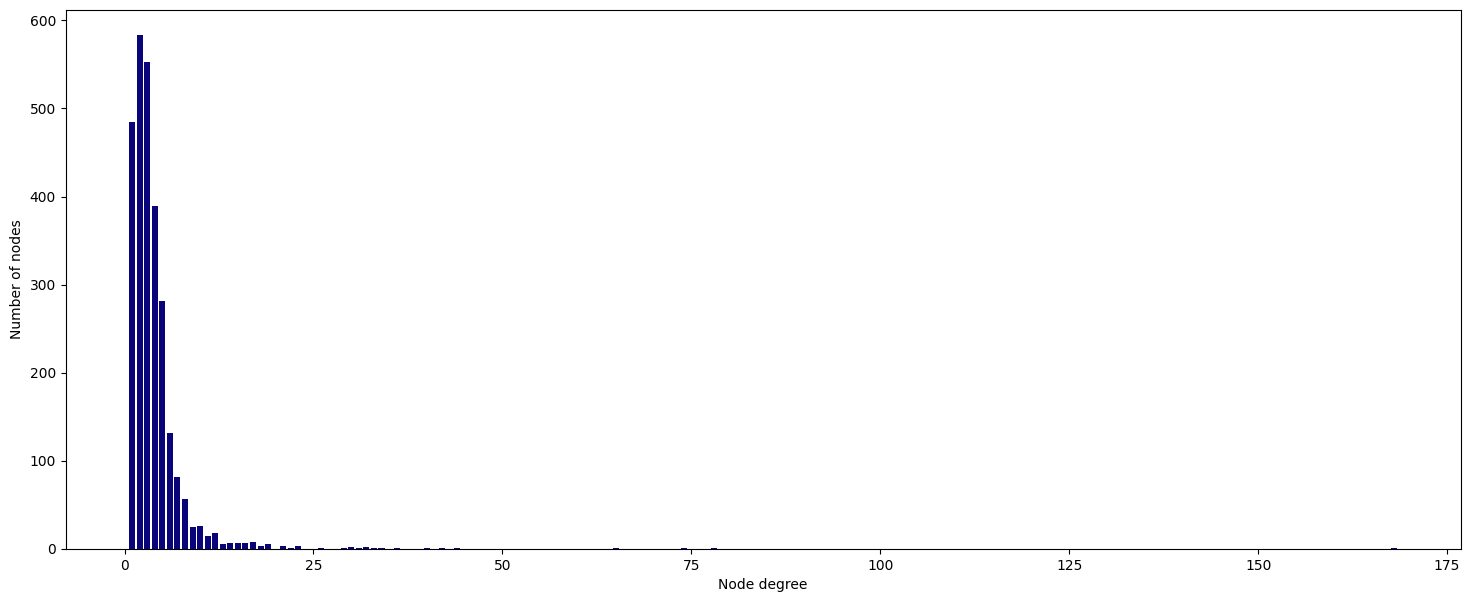

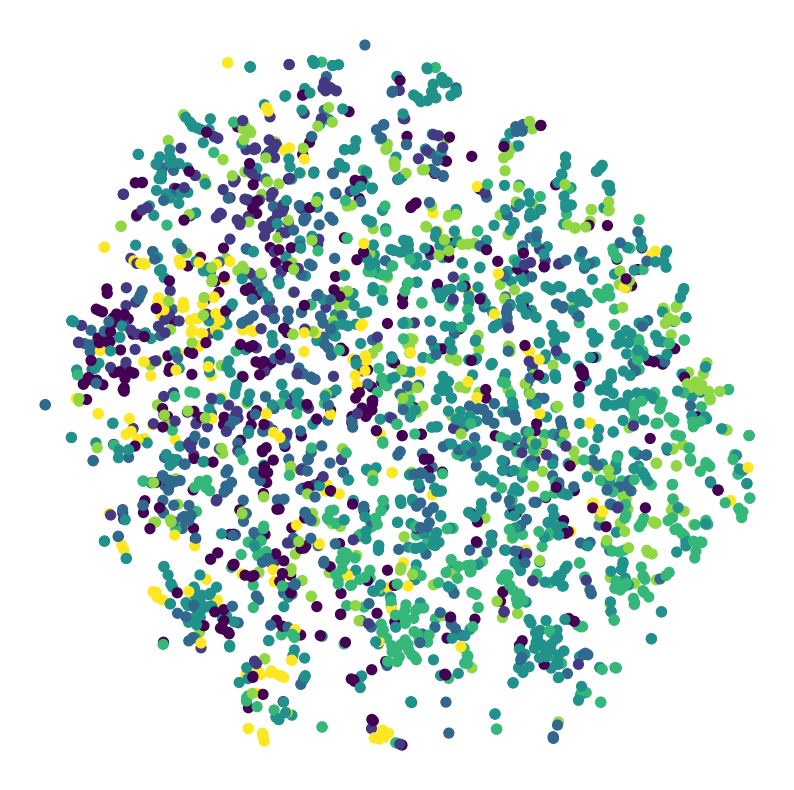

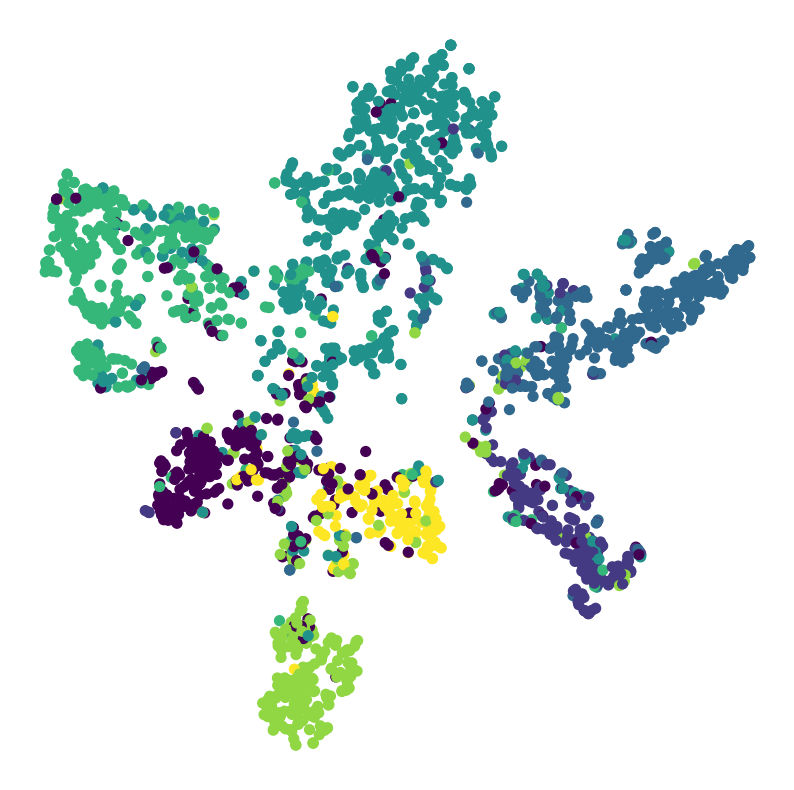

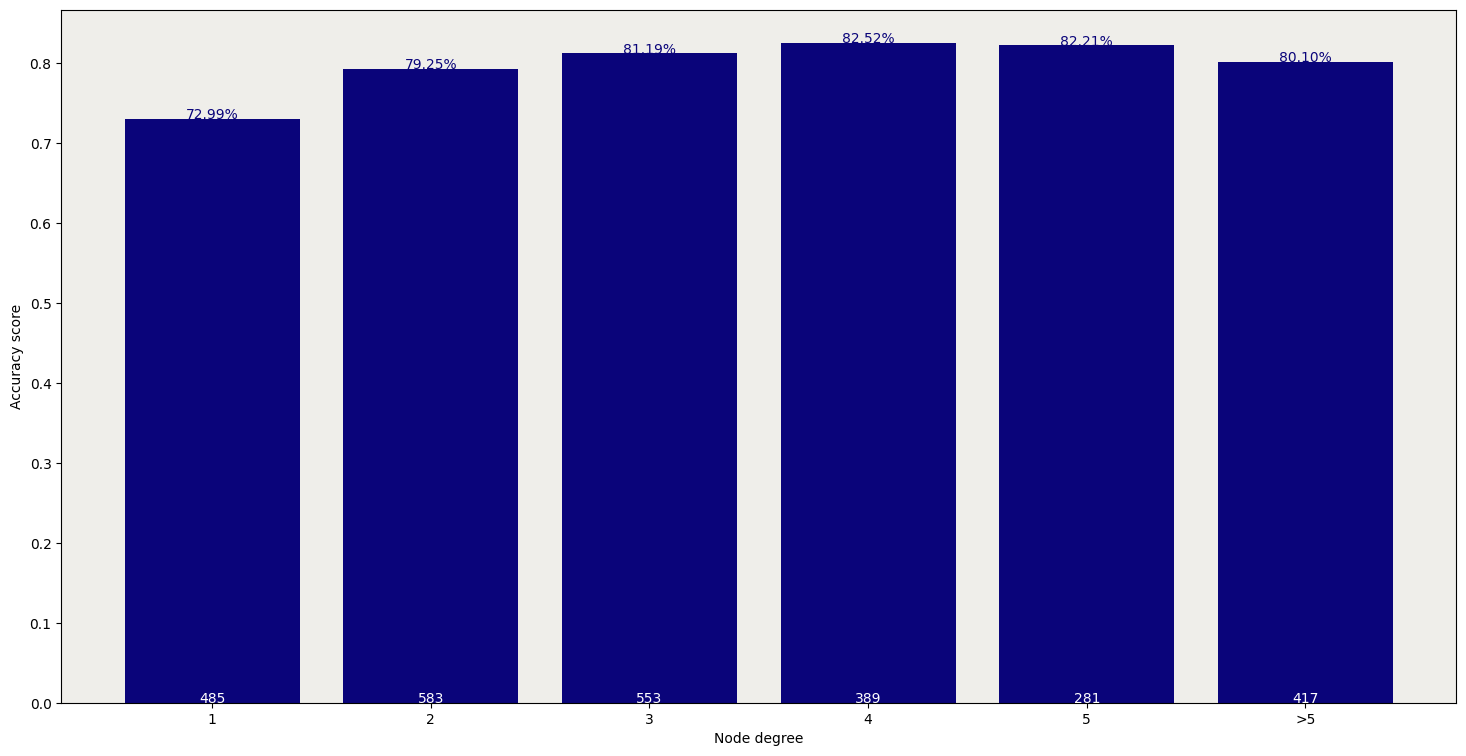

In [5]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.nn import Dropout, Linear
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATv2Conv, GCNConv
from torch_geometric.utils import degree


# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="Cora")

# Print information about the dataset
print(f"Number of graphs: {len(dataset)}")
print(f"Number of nodes: {dataset[0].x.shape[0]}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")
print(f"Has isolated nodes: {dataset[0].has_isolated_nodes()}")


# Get list of degrees for each node
degrees = degree(dataset.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel("Node degree")
ax.set_ylabel("Number of nodes")
plt.bar(numbers.keys(), numbers.values(), color="#0A047A")


class GAT(torch.nn.Module):
    """Graph Attention Network"""

    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(
            self.parameters(), lr=0.009, weight_decay=5e-4
        )

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200
    model.train()
    for epoch in range(epochs + 1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(
            out[data.train_mask].argmax(dim=1), data.y[data.train_mask]
        )
        loss.backward()
        optimizer.step()
        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])
        # Print metrics every 10 epochs
        if epoch % 10 == 0:
            print(
                f"Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: "
                f"{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | "
                f"Val Acc: {val_acc*100:.2f}%"
            )

    return model


def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc


# Create GAT
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, dataset)

# Test
acc = test(gat, dataset)
print(f"GAT test accuracy: {acc*100:.2f}%\n")


untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)
# Get embeddings
h, _ = untrained_gat(dataset.x, dataset.edge_index)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(
    h.detach()
)
# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=dataset.y)
plt.show()

h, _ = gat(dataset.x, dataset.edge_index)
# Train TSNE
tsne = TSNE(n_components=2, learning_rate="auto", init="pca").fit_transform(
    h.detach()
)
# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=dataset.y)
plt.show()


# Get model's classifications
_, out = gat(dataset.x, dataset.edge_index)

# Calculate the degree of each node
degrees = degree(dataset.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], dataset.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], dataset.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel("Node degree")
ax.set_ylabel("Accuracy score")
ax.set_facecolor("#EFEEEA")
plt.bar(["0", "1", "2", "3", "4", "5", ">5"], accuracies, color="#0A047A")
for i in range(0, 7):
    plt.text(
        i,
        accuracies[i],
        f"{accuracies[i]*100:.2f}%",
        ha="center",
        color="#0A047A",
    )
for i in range(0, 7):
    plt.text(
        i, accuracies[i] // 2, sizes[i], ha="center", color="white"
    )